# Introdução ao Aprendizado de Máquina com scikit-learn

Neste tutorial vamos apresentar uma introdução rápida ao Aprendizado de Máquina usando o [scikit-learn](scikit-learn.org).

## Requisitos

Neste tutorial, usamos as seguintes bibliotecas:

* Pandas
* NumPy
* SciPy
* scikit-learn

## Resumo

Vamos explorar o desafio [Titanic](https://www.kaggle.com/c/titanic) disponível no [Kaggle](http://kaggle.com). O objetivo deste desafio é prever quais pessoas vão sobreviver ao naufrágio do navio. Não muito útil, não é? Mas é um ótimo experimento para explorar técnicas de aprendizado de máquina.

Propomos este desafio em um dos encontro do [Meetup Joinville Machine Learning](http://joinville.ml) e brincamos com ele no Clube de Computação Aplicada do [Fab Lab Joinville](http://www.fablabjoinville.com.br). Os experimentos realizados aqui são uma mistura dos resultados obtidos pelos que realizaram o desafio. Um especial obrigado ao Guilherme que [documentou seus experimentos](https://guidefreitas.github.io/ia/machinelearning/2017/04/10/Kaggle-Titanic.html) e disponibilizou publicamente!

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

mpl.style.use('ggplot')
%matplotlib inline

# Cria as funções para mostrar os gráficos
# Source https://guidefreitas.github.io/ia/machinelearning/2017/04/10/Kaggle-Titanic.html
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_line(loss, ylabel, xlabel='Epochs'):
    fig = plt.figure()
    plt.plot(loss)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    plt.show()

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

## Dataset

São fornecidos dois arquivos no desafio, um para treinamento e um para testes.

In [2]:
train_df = pd.read_csv('data/raw/train.csv')
test_df = pd.read_csv('data/raw/test.csv')
dataset = pd.concat([test_df, train_df])

Vamos explorar um pouco os dados usando o Pandas.

In [3]:
print('COLUMNS', dataset.columns.values)
print('')
dataset.info()

COLUMNS ['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 890
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [4]:
dataset.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


Na tabela acima podemos perceber que existem dados faltantes nas colunas Cabin, Embarked, etc. Vamos dar uma olhada melhor nos dados não numéricos:

In [46]:
dataset.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Kelly, Mr. James",male,CA. 2343
freq,6,914,2,843,11


Vamos dar uma olhada nos valores únicos presentes em cada coluna:

In [5]:
for column in ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']:
    print(column, 'unique values:', dataset[column].unique())

Survived unique values: [ nan   0.   1.]
Pclass unique values: [3 2 1]
Sex unique values: ['male' 'female']
Age unique values: [ 34.5   47.    62.    27.    22.    14.    30.    26.    18.    21.      nan
  46.    23.    63.    24.    35.    45.    55.     9.    48.    50.    22.5
  41.    33.    18.5   25.    39.    60.    36.    20.    28.    10.    17.
  32.    13.    31.    29.    28.5   32.5    6.    67.    49.     2.    76.
  43.    16.     1.    12.    42.    53.    26.5   40.    61.    60.5    7.
  15.    54.    64.    37.    34.    11.5    8.     0.33  38.    57.    40.5
   0.92  19.    36.5    0.75   0.83  58.     0.17  59.    14.5   44.     5.
  51.     3.    38.5    4.    66.    65.    11.    71.    70.5   55.5   56.
  45.5   20.5   52.    23.5   80.    70.    24.5    0.67  30.5    0.42  74.  ]
SibSp unique values: [0 1 2 3 4 5 8]
Parch unique values: [0 1 3 2 4 6 5 9]
Fare unique values: [   7.8292    7.        9.6875    8.6625   12.2875    9.225     7.6292
   29.        7

 - **passengerid**: integer
 - **survived**: 0 or 1
 - **pclass** (ticket class): 1, 2 or 3 1st = Upper 2nd = Middle 3rd = Lower
 - **name** (passeger name): string
 - **sex** (passenger sex): 'male' or 'female'
 - **age** (passenger age): NaN and float
 - **sibsp** (number of siblings/spouses aboard the titanic): 1 0 3 4 2 5 8
 - **parch** (number of parents/children aboard the titanic): 0 1 2 5 3 4 6
 - **ticket**: string, alphanumeric
 - **fare**: float
 - **cabin** (cabin number): NaN, string, alphanumeric
 - **embarked** (port of embarkation): NaN, C = Cherbourg, Q = Queenstown, S = Southampton

Types:

- **categorical**: survived, pclass, sex, embarked
- **continous**: age, fare
- **discrete**: sibsp, parch
- **alphanumeric**: ticket, cabin, name
- **Null, NaN**: cabin, embarked, age

In [7]:
dataset.Cabin.isnull().count()

1309

## Análise

### Verificando a correção entre os dados

Scatter Plots são uma ótima maneira de determinar aproximadamente se você tem uma correlação linear entre várias variáveis. Isso é particularmente útil para localizar variáveis específicas que podem ter correlações semelhantes aos dados.

Mais em: https://www.wikiwand.com/en/Scatter_plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a1cfe48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b03ba20>]], dtype=object)

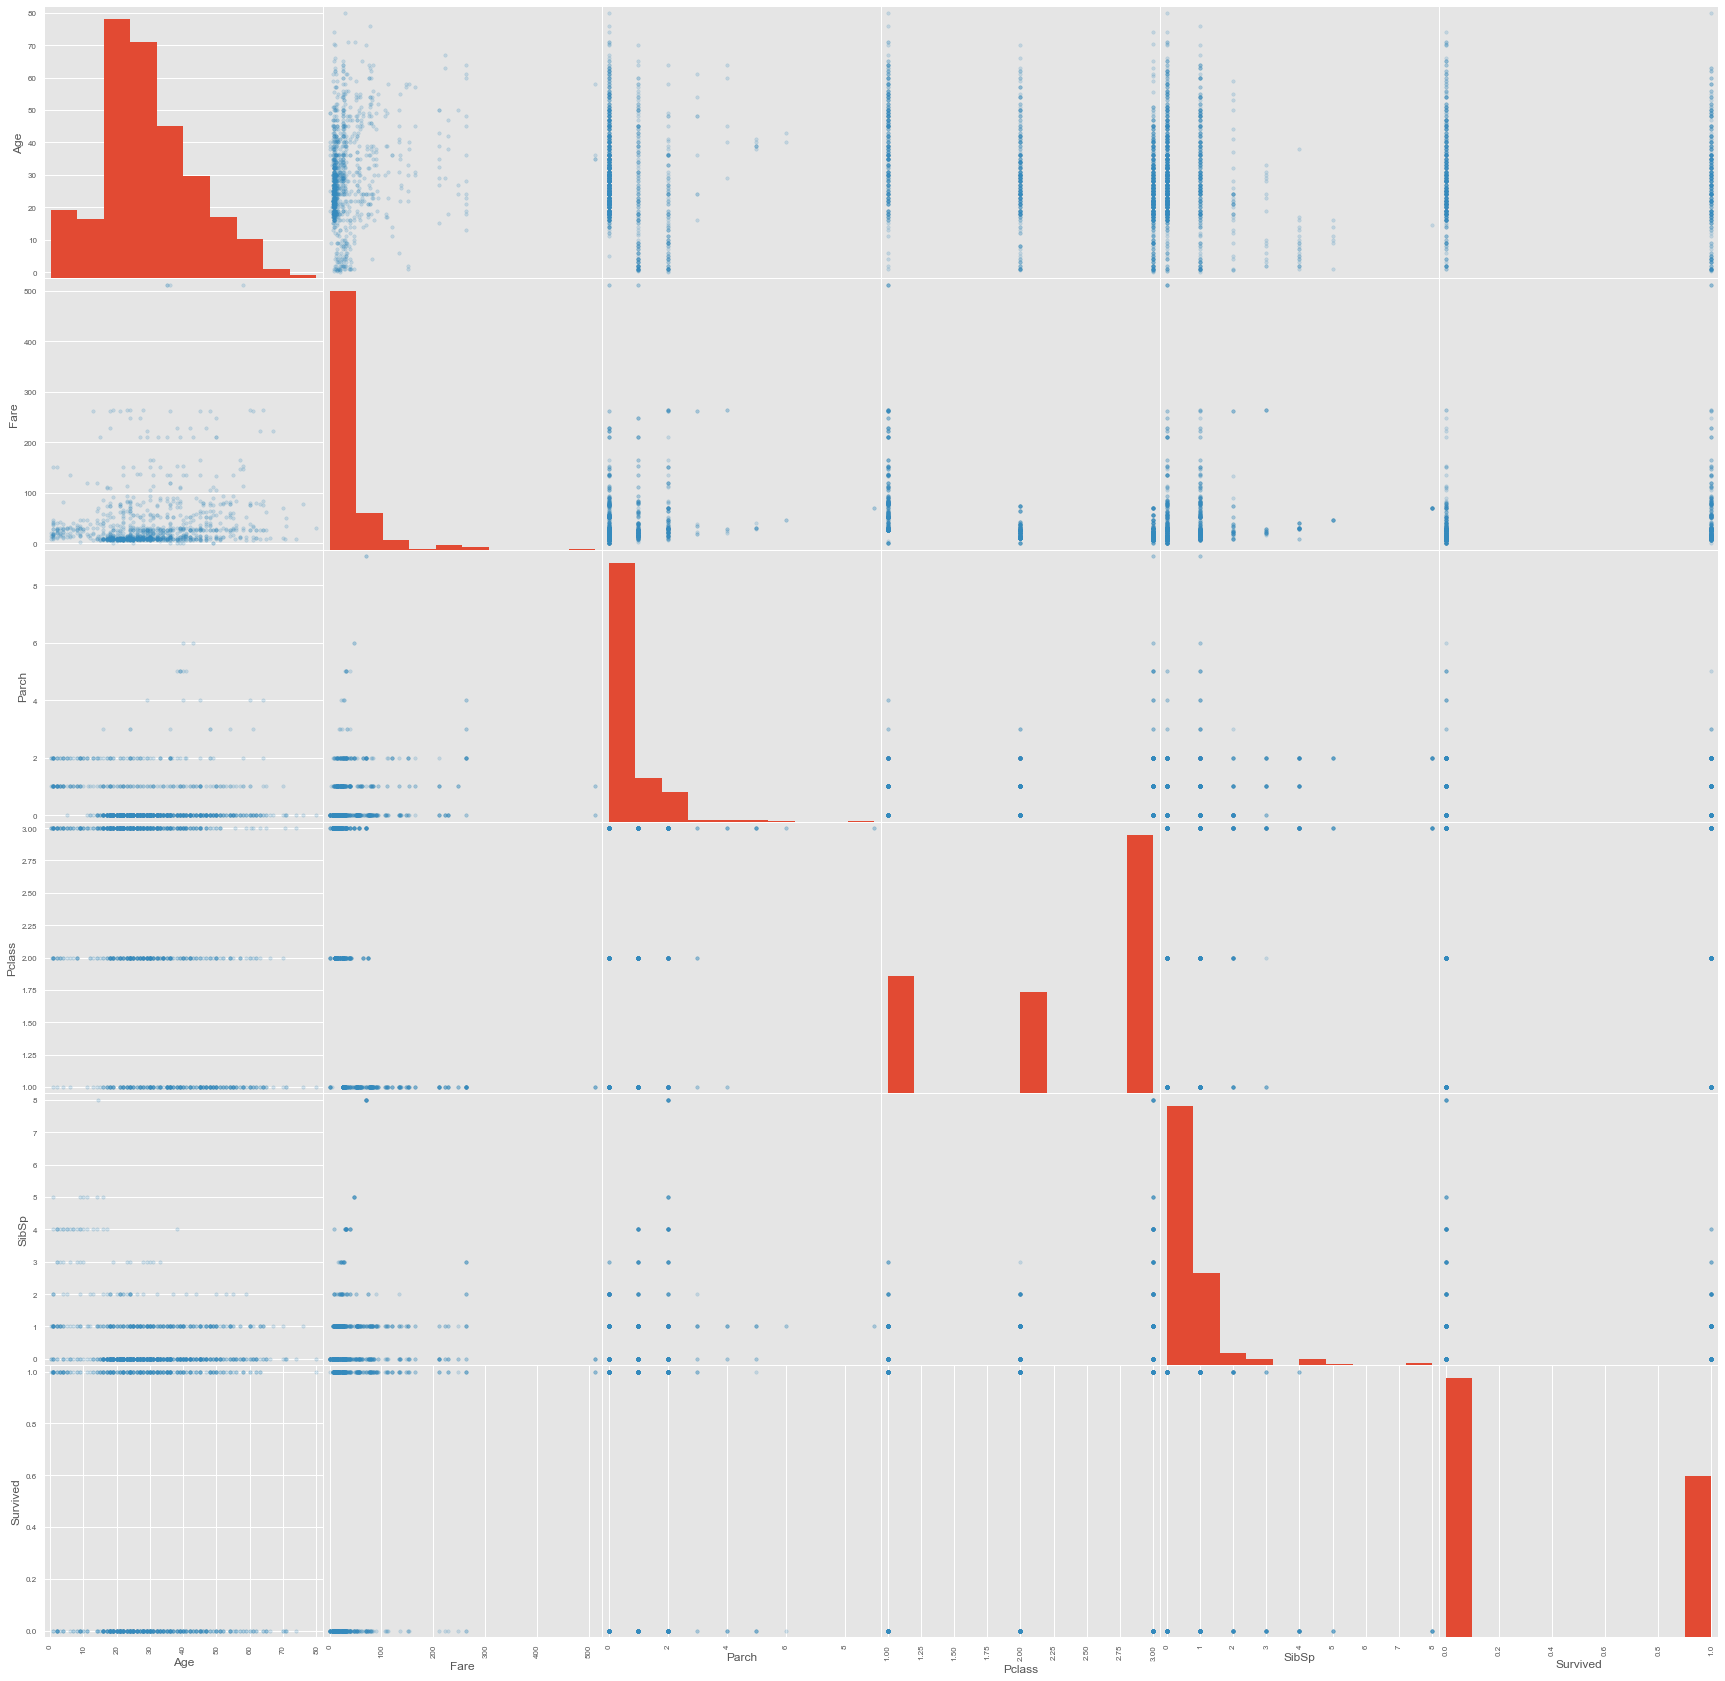

In [8]:
dataset = dataset.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

from pandas.tools.plotting import scatter_matrix
scatter_matrix(dataset, alpha=0.2, figsize=(30, 30), diagonal='hist')

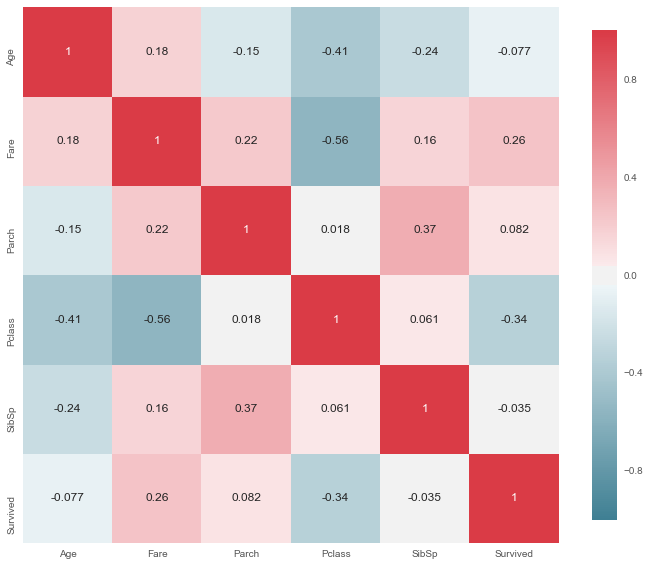

In [9]:
plot_correlation_map(dataset)

Quanto mais vermelho, maior a correlação. Repare que Sex e Fare influenciam muito a variável que estamos tentando inferir Survived. Como nós já sabemos, no acidente do Titanic mulheres e pessoas mais ricas tiveram mais chance de sobrevivência. Já a idade e o porto de embarque influenciam pouco.

Os gráficos de distribuição possibilitam observar a relação entre duas variáveis. No exemplo abaixo é possível observar que mais homens entre 0 e 10 anos e mulheres entre 30 e 40 anos sobreviveram.

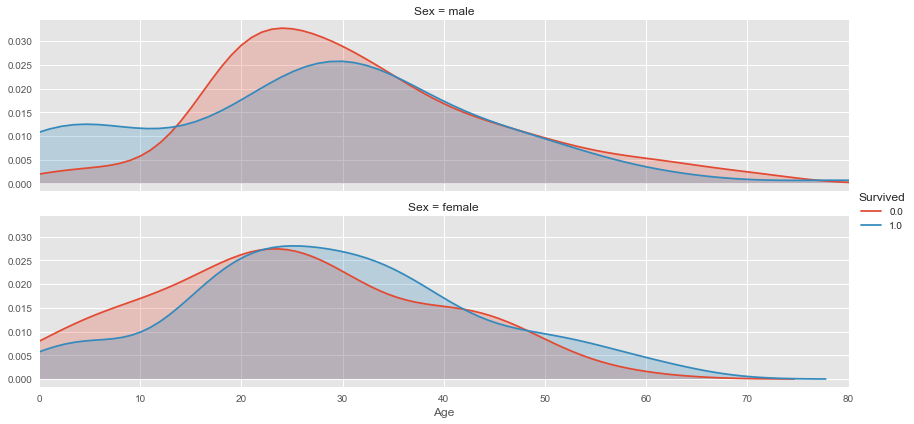

In [10]:
plot_distribution(dataset, var='Age', target='Survived', row='Sex')

Mostrando um gráfico de barras entre variáveis discretas é possível avaliar não somente a quantidade, mas também a variação entre a relação de duas variáveis. No exemplo abaixo é possível observar que o local de embarque dos passageiros não influenciou muito no fato de terem sobrevivido ou não.

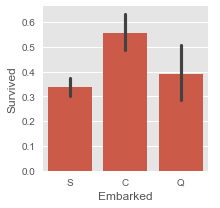

In [11]:
plot_categories(dataset, cat='Embarked', target='Survived')

E confirmamos novamente que mais mulheres sobreviveram do que homens.

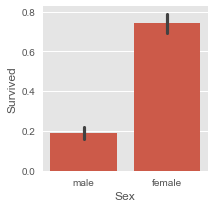

In [12]:
plot_categories(dataset, cat='Sex', target='Survived')

E a classe social.

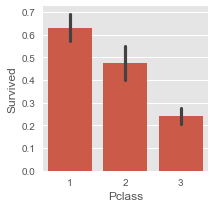

In [13]:
plot_categories(dataset, cat='Pclass', target='Survived')

## Pré-processamento

Baseando-se na nossa exploração inicial, podemos realizar um pré-processamento nos dados a fim de melhorar a qualidade do dataset. Abaixo segue uma sugestão de pré-processamento para cada coluna.

### PREPROCESSING TODO

- [X] Remover PassangerId
- [X] Remover Ticket
- [X] Remover Name
- [X] Converter Sex para valores numéricos 
- [X] Converter Embarked para valores numéricos
- [X] Arrumar Age (existem NaN)
- [X] Arrumar Embarked (existem NaN)
- [X] Converter Age para um range
- [X] Converter Fare para um range
- [ ] Explorar melhor os dados das colunas Cabin e Ticket. Com algum pré-processamento podem ser úteis

### Remover PassengerId, Name, Ticket e Cabin. 

Removemos os dados que parecem não fazer diferença para classificação. O Ticket e Cabin podem ser exploradores depois. Podemos também tentar explorar a saudação presente no nome (Mr, Sr, etc). PassengerId certamente não ajuda no nosso trabalho.

In [14]:
# Removemos lá em cima na análise dos dados
# dataset = dataset.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

### Converter Sex e Embarked para valores numéricos

Para deixar os dados úteis para classificação, convertemos os valores não numéricos para numéricos.

In [15]:
replace = {'Sex': {'male': 0, 'female': 1}, 'Embarked': {'C': 0, 'Q': 1, 'S': 2}}
dataset = dataset.replace(replace)

In [16]:
print(dataset.Embarked.isnull().sum())
dataset.groupby('Embarked').Embarked.count()

2


Embarked
0.0    270
1.0    123
2.0    914
Name: Embarked, dtype: int64

In [17]:
dataset.Embarked = dataset.Embarked.fillna(2)

In [18]:
dataset.Embarked.isnull().sum()

0

### Adicionar dados faltantes

Um grande problema que sempre vamos encontrar ao trabalharmos com dados são os dados faltantes. No nosso dataset, como vimos antes, colunas como Age tem muito dados faltantes.

Existem algumas estratégias para resolver este problema, a mais popular é preencher os dados com a mediada dos valores existentes, dessa forma a distribuição dos dados não é afetada, reduzindo sua influência nos resultados de classificação. Outra estratégia comum é remover as linhas com dados nulos. Outras análises mais complexas podem ser feitas, como verificar a correlação da idade com outras colunas para escolher melhor a idade para data entrada de dados.

Aqui vamos e mediana.

In [19]:
dataset.Age = dataset.Age.fillna(dataset.Age.mean())

In [20]:
dataset.Age.isnull().sum()

0

In [21]:
dataset.Fare = dataset.Fare.fillna(dataset.Fare.mean())

In [22]:
dataset.Fare.isnull().sum()

0

### Melhorando o formato dos dados textuais

Podemos ainda criar novas colunas com valores 0 e 1 para valores únicos da coluna. Então ao invés de termos uma coluna com uma sequência numérica 0, 1, 2, teremos colunas com os valores 0 ou 1, indicando se aquele dado está presente ou não. A tendência é que nessas colunas apenas uma delas tenha o valor 1. 

In [23]:
embarked = pd.get_dummies(dataset.Embarked, prefix='Embarked')
pclass = pd.get_dummies(dataset.Pclass, prefix='Pclass')

In [24]:
embarked.head()

,Embarked_0.0,Embarked_1.0,Embarked_2.0
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


In [25]:
dataset = pd.concat([dataset, embarked, pclass] , axis=1)
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_0.0,Embarked_1.0,Embarked_2.0,Pclass_1,Pclass_2,Pclass_3
0,34.5,NaN,1.0,7.8292,0,3,0,0,NaN,0,1,0,0,0,1
1,47.0,NaN,2.0,7.0000,0,3,1,1,NaN,0,0,1,0,0,1
2,62.0,NaN,1.0,9.6875,0,2,0,0,NaN,0,1,0,0,1,0
3,27.0,NaN,2.0,8.6625,0,3,0,0,NaN,0,0,1,0,0,1
4,22.0,NaN,2.0,12.2875,1,3,1,1,NaN,0,0,1,0,0,1


Quando a variável faltante não é numérica é possível criar uma nova variável representando os dados faltantes. Abaixo todas as cabines com dados faltantes passam a ter o valor U. Em seguida são criadas e populadas colunas correspondentes a cada cabine.

In [26]:
cabin = pd.DataFrame()

# Substitui os dados de cabines faltantes com U (Unknown)
cabin.Cabin = dataset.Cabin.fillna('U')

# Mapping each Cabin value with the cabin letter
cabin.Cabin = cabin.Cabin.map(lambda c: c[0])
cabin = pd.get_dummies(cabin.Cabin, prefix='Cabin')

dataset = pd.concat([dataset, cabin], axis=1)

cabin.tail()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
886,0,0,0,0,0,0,0,0,1
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0,1
889,0,0,1,0,0,0,0,0,0
890,0,0,0,0,0,0,0,0,1


In [27]:
dataset.tail()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_0.0,...,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
886,27.000000,NaN,2.0,13.00,0,2,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
887,19.000000,B42,2.0,30.00,0,1,1,0,1.0,0,...,0,0,1,0,0,0,0,0,0,0
888,29.881138,NaN,2.0,23.45,2,3,1,1,0.0,0,...,1,0,0,0,0,0,0,0,0,1
889,26.000000,C148,0.0,30.00,0,1,0,0,1.0,1,...,0,0,0,1,0,0,0,0,0,0
890,32.000000,NaN,1.0,7.75,0,3,0,0,0.0,0,...,1,0,0,0,0,0,0,0,0,1


In [28]:
dataset = dataset.drop(['Cabin', 'Embarked', 'Pclass'], axis=1)

In [29]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Embarked_0.0,Embarked_1.0,Embarked_2.0,Pclass_1,...,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,34.5,7.8292,0,0,0,NaN,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,47.0,7.0000,0,1,1,NaN,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,0,0,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,27.0,8.6625,0,0,0,NaN,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,1,1,1,NaN,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


### Função de pré-processamento

Vamos colocar tudo isso dentro de uma função.

In [6]:
def preprocessing(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    replace = {'Sex': {'male': 0, 'female': 1}, 'Embarked': {'C': 0, 'Q': 1, 'S': 2}}
    df = df.replace(replace)
    df.Embarked = df.Embarked.fillna(2)
    df.Age = df.Age.fillna(dataset.Age.mean())
    df.Fare = df.Fare.fillna(dataset.Fare.mean())
    
    embarked = pd.get_dummies(df.Embarked, prefix='Embarked')
    pclass = pd.get_dummies(df.Pclass, prefix='Pclass')
    
    cabin = pd.DataFrame()
    cabin.Cabin = df.Cabin.fillna('U')
    cabin.Cabin = cabin.Cabin.map(lambda c: c[0])
    cabin = pd.get_dummies(cabin.Cabin, prefix='Cabin')

    df = pd.concat([df, cabin, embarked, pclass] , axis=1)
    df = df.drop(['Cabin', 'Embarked', 'Pclass'], axis=1)
    
    # Normalizando os dados
    norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    df.Age = norm.Age
    df.Fare = norm.Fare
    
    return df

In [7]:
train_valid_features = preprocessing(train_df)
test_features = preprocessing(test_df)
test_features['Cabin_T'] = 0

In [8]:
train_valid_features.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_0.0,Embarked_1.0,Embarked_2.0,Pclass_1,Pclass_2,Pclass_3
0,0,0,-0.097201,1,0,-0.048707,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,1,1,0.103854,1,0,0.076277,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,-0.046937,0,0,-0.047390,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,1,1,0.066156,1,0,0.040786,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0.066156,0,0,-0.047146,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [9]:
test_features.head()

,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3,Cabin_T
0,0,0.056811,0,0,-0.054247,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,1,0.221653,1,0,-0.055866,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,0,0.419464,0,0,-0.050620,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,0,-0.042095,0,0,-0.052621,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,1,-0.108032,1,1,-0.045545,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


## Treinamento de modelos

Nosso objetivo neste desafio é treinar um modelo que nos ajude a classificar se uma pessoa sobreviveria ou morreria no acidente do Titanic baseado nos dados que temos disponíveis. 

Nós já sabemos quem morreu no acidente. Porém, após termos um modelo confiável treinado, podemos mostrar para ele dados de pessoas que não estavam no Titanic para ver qual seria a probabilidade dessa pessoa morrer no acidente.

Como identificamos na nossa análise, existem fatores óbvios que influenciam nisso como idade, sexo e renda. Poderíamos tentar fazer uma predição manual a partir desses dados, ou mesmo usar modelos onde conseguimos forçar pesos para cada atributo, como Redes Bayesianas.

Uma coisa para ter em mente: **Comece pelo algoritmo mais simples, sempre que possível**. É comum querermos usar os últimos algoritmos disponíveis, porém também é comum notarmos que estamos _over engineering_ o problema.

Nosso objetivo no final do dia, é achar os melhores parâmetros para uma curva. Supondo um problema onde estamos analizando dois atributos, usando um classificador linear, teríamos

![](docs/linear-regression-example.png)

#### Models lineares e não lineares

Os modelos lineares são lineares nos parâmetros que devem ser estimados, mas não necessariamente nas variáveis independentes. Isso explica por que o gráfico do meio das três figuras abaixo mostra uma linha de discriminação linear entre as duas classes, embora a linha não seja linear no sentido de uma linha reta.

Normalmente, os modelos não lineares são mais poderosos, podem representar uma maior classe de funções, mas muito mais difíceis de treinar.

![](docs/linear-nonlinear-examples.png)
<center>[Referência](http://www.statistics4u.com/fundstat_eng/cc_linvsnonlin.html)</center>

### Métricas

![](docs/precision-recall.png)
<center>[Referência](https://www.wikiwand.com/en/Precision_and_recall)</center>

In [10]:
from sklearn.model_selection import train_test_split

train_valid_labels = train_valid_features.Survived
train_valid_features = train_valid_features.drop('Survived', axis=1)
train_features, valid_features, train_labels, valid_labels = train_test_split(train_valid_features, train_valid_labels, train_size=0.7)

### Logistic Regression 

[Documentação](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
[Tutorial](http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/)
[Logistic Function](https://www.wikiwand.com/en/Logistic_function)

No regressor logístico tenta-se prever a probabilidade de um dado exemplo pertencer a classe de sobreviventes versos a probabilidade de percenter a classe de falecidos.

$f(x) = \frac{L}{1 + \mathrm e^{-k(x-x_0)}}$


![](docs/logistic-curve.png)
Para a curva padrão
$L=1,k=1,x_0=0$

#### Um exemplo

![](docs/logistic-regression-example.jpg)
<center>[Referência](https://www.mssqltips.com/sqlservertip/3471/introduction-to-the-sql-server-analysis-services-logistic-regression-data-mining-algorithm/)</center>

In [11]:
from sklearn.linear_model import LogisticRegression

classifier_lor = LogisticRegression()
classifier_lor.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
classifier_lor.score(valid_features, valid_labels)

0.84701492537313428

In [12]:
from sklearn.metrics import classification_report

valid_labels_predicted_lor = classifier_lor.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_lor, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.87      0.90      0.88       172
 Sobreviveu       0.81      0.75      0.78        96

avg / total       0.85      0.85      0.85       268



### Stocastic Gradient Descent 

[Documentação](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
[Tutorial](http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/)

![](docs/sgd-git-example.gif)
<center>[Referência](http://dsdeepdive.blogspot.com.br/2016/03/optimizations-of-gradient-descent.html)</center>

In [13]:
from sklearn.linear_model import SGDClassifier

classifier_slr = SGDClassifier(loss='log', penalty='l1')
classifier_slr.fit(train_features, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [15]:
classifier_slr.score(valid_features, valid_labels)

0.71641791044776115

In [17]:
valid_labels_predicted_slr = classifier_slr.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_slr, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.91      0.62      0.74       172
 Sobreviveu       0.57      0.90      0.69        96

avg / total       0.79      0.72      0.72       268



### SVM

[Documentação](http://scikit-learn.org/stable/modules/svm.html)

Usa um subconjunto de pontos de treinamento na função de decisão (chamados vetores de suporte), portanto é eficiente na memória.

![](docs/svm-example.jpg)
<center>[Referência](http://www-personal.umich.edu/~johnhugo/commercial/inc/img/SVM.jpg)</center>

In [35]:
from sklearn import svm

classifier_svm = svm.SVC(probability=True)
classifier_svm.fit(train_features, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
classifier_svm.score(valid_features, valid_labels)

0.84328358208955223

In [37]:
valid_labels_predicted_svm = classifier_svm.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_svm, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.85      0.91      0.88       172
 Sobreviveu       0.82      0.72      0.77        96

avg / total       0.84      0.84      0.84       268



### Decision Tree

[Documentação](http://scikit-learn.org/stable/modules/tree.html)
[Tutorial](http://www.r2d3.us/uma-introducao-visual-ao-aprendizado-de-maquina-1/)

Por exemplo, no exemplo abaixo, as árvores de decisão aprendem com dados para aproximar uma curva de seno com um conjunto de regras de decisão if-then-else. Quanto mais profunda for a árvore, mais complexa será a decisão e mais ajustada ao modelo.

![](docs/decision-tree-examplee.png)
<center>[Referência](https://sebastianraschka.com/faq/docs/bagging-boosting-rf.html)</center>

In [25]:
from sklearn import tree

classifier_dt = tree.DecisionTreeClassifier()
classifier_dt.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [26]:
classifier_dt.score(valid_features, valid_labels)

0.77238805970149249

In [28]:
valid_labels_predicted_dt = classifier_dt.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_dt, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.82      0.82      0.82       172
 Sobreviveu       0.68      0.69      0.68        96

avg / total       0.77      0.77      0.77       268



### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier 

classifier_rf = RandomForestClassifier(n_estimators = 100)
classifier_rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
classifier_rf.score(valid_features, valid_labels)

0.80597014925373134

In [42]:
valid_labels_predicted_rf = classifier_rf.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_rf, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.83      0.88      0.85       172
 Sobreviveu       0.76      0.67      0.71        96

avg / total       0.80      0.81      0.80       268



### MLP (Multi-layer Perceptron)

In [60]:
from sklearn.neural_network import MLPClassifier

classifier_mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1)
classifier_mlp.fit(train_features, train_labels)

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [61]:
classifier_mlp.score(valid_features, valid_labels)

0.75

In [62]:
valid_labels_predicted_mlp = classifier_mlp.predict(valid_features)
print(classification_report(valid_labels, valid_labels_predicted_mlp, target_names=['Morreu', 'Sobreviveu']))

             precision    recall  f1-score   support

     Morreu       0.76      0.88      0.82       172
 Sobreviveu       0.71      0.51      0.59        96

avg / total       0.74      0.75      0.74       268



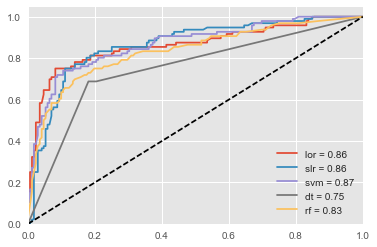

In [38]:
from sklearn.metrics import roc_curve, auc

classifiers_probs = [
    ('lor', classifier_lor.predict_proba(valid_features)[:, 1]),
    ('slr', classifier_slr.predict_proba(valid_features)[:, 1]),
    ('svm', classifier_svm.predict_proba(valid_features)[:, 1]),
    ('dt', classifier_dt.predict_proba(valid_features)[:, 1]),
    ('rf', classifier_rf.predict_proba(valid_features)[:, 1])
]

for classifier_name, proba in classifiers_probs:
    fpr, tpr,_ = roc_curve(valid_labels, proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='%s = %.2f' % (classifier_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

In [ ]:
classifier_lor.fit(train_features, train_labels)

## Explorando mais

* [Persistência do modelo](http://scikit-learn.org/stable/modules/model_persistence.html)
* Como fazer deploy do modelo?
* Pipeline de treinamento
* Entendendo as métricas de avaliação, quando usar ROC, quando usar Precision-Recall? MSE, RMSE
* Buscando os melhores parâmetros no modelo (GridSearch)